<a href="https://colab.research.google.com/github/Allessyer/Bayesian-Optimization-in-LPA/blob/main/Task%203.%202%20parameters/exp2_bo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 2

## Dummy problem

In [ ]:
import torch
import numpy as np
import plotly
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt


from botorch.models import SingleTaskGP,ModelListGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition import ExpectedImprovement, ProbabilityOfImprovement, qMaxValueEntropy
from botorch.optim import optimize_acqf
from botorch.utils import standardize

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

### Objective function

In [ ]:
#The range is bounded to -10.0 and 10.0 and one global optimal at [0.0, 0.0].
# objective function
def unimodal_func2(X1, X2):
    return 0.26 * (X1**2 + X2**2) - 0.48 * X1 * X2

#The range is bounded to -5.0 and 5.0 and one global optimal at [0.0, 0.0].
def unimodal_func1(X1,X2):
    return X1**2.0 + X2**2.0

# objective function
def unimodal_func3(X1, X2):
    return -torch.cos(X1) * torch.cos(X2) * torch.exp(-((X1 - torch.pi)**2 + (X2 - torch.pi)**2))

### Generate data

In [ ]:
def create_real_data(r_min, r_max,step,function,BO_test_func=False):
    X1 = torch.arange(r_min, r_max, step)
    X2 = torch.arange(r_min, r_max, step)
    X1_real, X2_real = torch.meshgrid(X1, X2)
    if BO_test_func:
        Y_real = np.zeros((X1_real.shape[0], X1_real.shape[1]))
        for i in range (X1_real.shape[0]):
            for j in range (X1_real.shape[1]):
                x = torch.Tensor([X1_real[i][j],X2_real[i][j]]).reshape(1,-1)
                y = function(x)
                Y_real[i][j] = y
    else:
        Y_real = function(X1_real, X2_real)
        
    return X1_real,X2_real,Y_real
  
def generate_initial_data(r_min,r_max,function,n_points=10,BO_test_func=False):
    d = 2
    bounds = torch.stack([r_min * torch.ones(d), r_max * torch.ones(d)])

    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(n_points, d)
    if BO_test_func:
        train_y = function(train_x).unsqueeze(-1)
    else:
        train_y = function(train_x[:,0],train_x[:,1]).unsqueeze(-1)

    return train_x,train_y,bounds

### Gaussian Process and acquisition functions

In [ ]:
def init_GP(x_train,y_train):
    # 1. Создаем гауссовский процесс
    gaussian_process = SingleTaskGP(x_train,y_train) 
    mll = ExactMarginalLogLikelihood(gaussian_process.likelihood,gaussian_process) 
    # 2. Обучаем гауссовский процесс
    fit_gpytorch_model(mll) 

    # 3. Создаем acquisition function
    best_y_train = y_train.min()
    acquisition_function = ExpectedImprovement(
    model=gaussian_process,
    best_f=best_y_train,
    maximize=False
    )
    return gaussian_process,acquisition_function

def get_next_points(x_train, y_train, bounds, n_points=1):
    gaussian_process,acquisition_function = init_GP(x_train,y_train)

    # 4. Оптимизируем acquisition function и получаем нового кандидата
    candidates,_ = optimize_acqf(
    acq_function=acquisition_function,
    bounds=bounds,
    q=n_points,
    num_restarts=200,
    raw_samples=512,
    options={'batch_limit': 5,'maxiter': 200}
    )
    return candidates,gaussian_process,acquisition_function

### Plot 3D functions

In [ ]:
def plot_3d_real_train(X,Y,Z,x_train,y_train):
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap='gist_earth',
                        linewidth=0, antialiased=False,alpha=0.4)

    ax.scatter(x_train[:,0].cpu().numpy(),x_train[:,1].cpu().numpy(), y_train.cpu().numpy(), color = 'red', s=100)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    ax.set_xlabel('$X_1$', fontsize=20)
    ax.set_ylabel('$X_2$',fontsize=20)
    ax.set_zlabel(r'$Y$', fontsize=30)

    plt.show()


def plot_result(X1_real,X2_real,Y_real,x_train,y_train,gaussian_process,acquisition_function,candidate,BO_test_func=False):

    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')

    # Plot real function.
    if BO_test_func:
        surf = ax.plot_surface(X1_real, X2_real, Y_real, cmap='gist_earth',
                        linewidth=0, antialiased=False,alpha=0.2)
    else:
        surf = ax.plot_surface(X1_real.cpu().numpy(), X2_real.cpu().numpy(), Y_real.cpu().numpy(), cmap='gist_earth',
                        linewidth=0, antialiased=False,alpha=0.2)

    # Plot existing data: x_train, y_train
    x_train = x_train.cpu().numpy()
    y_train = y_train.cpu().numpy()

    ax.scatter(x_train[:-1,0],x_train[:-1,1], y_train[:-1], color = 'gray', s=100)
    ax.scatter(x_train[-1,0],x_train[-1,1], y_train[-1], color = 'red', s=30)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    ax.set_xlabel('$X_1$', fontsize=20)
    ax.set_ylabel('$X_2$',fontsize=20)
    ax.set_zlabel(r'$Y$', fontsize=30)

    # Plot acquisition function

    X_real = torch.stack([X1_real.reshape(X1_real.shape[0]*X1_real.shape[1], 1), X2_real.reshape(X2_real.shape[0]*X2_real.shape[1], 1)], -1)
    print("X_real shape = ", X_real.shape)
    Y_acqui = acquisition_function(X_real)
    print("Y_acqui shape = ", Y_acqui.shape)

    Xraw1 = X_real.reshape((X1_real.shape[0],X1_real.shape[1],2)).detach().numpy()
    Yraw1 = Y_acqui.reshape(X1_real.shape[0],X1_real.shape[1]).detach().numpy()
    print("Xraw1 shape = ", Xraw1.shape)
    print("Yraw1 shape = ", Yraw1.shape)

    ax.contourf(Xraw1[:,:,0],Xraw1[:,:,1],Yraw1)

    ax.scatter(candidate[:,0].cpu(),candidate[:,1].cpu(),marker="X",c="black", s=30)
    ax.scatter(0.0, 0.0, marker = '*',c = "yellow",s = 30)

    # ax.view_init(50, 35)

    plt.show()

    plt.contourf(Xraw1[:,:,0],Xraw1[:,:,1],Yraw1)

    plt.scatter(candidate[:,0].cpu(),candidate[:,1].cpu(),marker="X",c="black",label = 'new candidate')
    plt.scatter(0.0, 0.0, marker='*', c='yellow',label = "real optimum")
    plt.legend()
    plt.colorbar();
    plt.show()

### BO function

In [ ]:
def Bayesian_Optimization(r_min, r_max,x_train,y_train,bounds,function,n_steps,BO_test_func=False):
    X1_real,X2_real,Y_real = create_real_data(r_min, r_max,0.1,function,BO_test_func=BO_test_func)

    for step in range(n_steps):
        print(f'Nr. of optimization step: {step}')
        x_pred,gaussian_process,acquisition_function = get_next_points(x_train, y_train, bounds, n_points=1)
        if BO_test_func:
            y_pred = function(x_pred).unsqueeze(-1)
        else:
            y_pred = function(x_pred[:,0],x_pred[:,1]).unsqueeze(-1)

        print(f'New candidates are: {x_pred}')

        # Add new candidates to x_train
        x_train = torch.cat([x_train, x_pred])
        y_train = torch.cat([y_train, y_pred])

        # Find new best result
        best_y_train = y_train.min().item()
        print(f'Best point performs this way: {best_y_train}')
        print(X1_real.dtype,X2_real.dtype,x_train.dtype,y_train.dtype,x_pred.dtype)

        if BO_test_func:
            plot_result(X1_real,X2_real,Y_real,x_train,y_train,gaussian_process,acquisition_function,x_pred,BO_test_func=True)
        else:
            plot_result(X1_real,X2_real,Y_real,x_train,y_train,gaussian_process,acquisition_function,x_pred)

    return x_train,y_train

### Whole process

In [ ]:
r_min = -5.0
r_max = 5.0
x_train,y_train,bounds = generate_initial_data(r_min,r_max,unimodal_func1,n_points=10)

In [ ]:
bounds

tensor([[-5., -5.],
        [ 5.,  5.]])

In [ ]:
x_train,y_train = Bayesian_Optimization(r_min,r_max,x_train,y_train,bounds,unimodal_func1,n_steps=10)

In [ ]:
print('Minimum y: ',torch.min(y_train))
print(f'Minimum x: {x_train[torch.argmin(y_train)]}')

Minimum y:  tensor(0.0415)
Minimum x: tensor([0.0008, 0.2037])


## Оборачиваем все в одну папку

In [ ]:
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

In [ ]:
from my_functions.bo2d_functions import generate_initial_data_2D
from my_functions.bo2d_functions import target_function_2D

### Objective function

In [ ]:
#The range is bounded to -5.0 and 5.0 and one global optimal at [0.0, 0.0].
def unimodal_func1(x1,x2):
    y = x1**2.0 + x2**2.0
    return y

### Generate initial dataset

In [ ]:
r_min = [-5.,-5.]
r_max = [5.,5.]
n_points = 5

objective_function = lambda x1,x2: unimodal_func1(x1,x2)

In [ ]:
x_train, y_train, bounds = generate_initial_data_2D(r_min, r_max, objective_function,n_points)

### Gaussian Process and Acquisition function

In [ ]:
def init_GP(x_train,y_train):
    # 1. Создаем гауссовский процесс
    gaussian_process = SingleTaskGP(x_train,y_train) 
    mll = ExactMarginalLogLikelihood(gaussian_process.likelihood,gaussian_process) 
    # 2. Обучаем гауссовский процесс
    fit_gpytorch_model(mll) 

    # 3. Создаем acquisition function
    best_y_train = y_train.min()
    acquisition_function = ExpectedImprovement(
    model=gaussian_process,
    best_f=best_y_train,
    maximize=False
    )
    return gaussian_process,acquisition_function

def get_next_points(x_train, y_train, bounds, n_points=1):
    gaussian_process,acquisition_function = init_GP(x_train,y_train)

    # 4. Оптимизируем acquisition function и получаем нового кандидата
    candidates,_ = optimize_acqf(
    acq_function=acquisition_function,
    bounds=bounds,
    q=n_points,
    num_restarts=200,
    raw_samples=512,
    options={'batch_limit': 5,'maxiter': 200}
    )
    return candidates,gaussian_process,acquisition_function

### Plot functions

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
rcParams['axes.labelpad'] = 20
import numpy as np
from matplotlib import cm
from my_functions.bo2d_functions import create_x_train

In [ ]:
def plot_result(x_train,y_train,gaussian_process,acquisition_function):
    
    # Plot existing data: x_train, y_train
    x_train = x_train.cpu().numpy()
    y_train = y_train.cpu().numpy()

    font = {'family': 'serif',
    'color':  '#484441',   
    'weight': 'normal',
    'size': 16,
    }

    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')

    ax.scatter(x_train[:5,0],x_train[:5,1], y_train[:5], color = 'gray', s=50,label="initial data")
    ax.scatter(x_train[5:-1,0],x_train[5:-1,1], y_train[-1], color = 'black', s=30, label='Observed data')
    ax.scatter(x_train[-1,0],x_train[-1,1], y_train[-1], color = 'red', s=30, label='last candidate')

    ax.set_xlabel('$X_1$', fontdict=font)
    ax.set_ylabel('$X_2$',fontdict=font)
    ax.set_zlabel(r'$Y$', fontdict=font)
    ax.tick_params(labelcolor='blue', labelsize=13, width=10)

    ax.legend()
    ax.view_init(elev=25., azim=50)

    # plot acquisition function
    r_min = bounds[0]
    r_max = bounds[1]

    x_data, _ = create_x_train(r_min, r_max, n_points=500, dim = 2)

    x_grid = x_data.unsqueeze(-2)
    with torch.no_grad():
        acqu = acquisition_function(x_grid).cpu().numpy()

    plt.tricontourf(x_data[:,0], x_data[:,1], acqu)
    plt.colorbar();
    plt.show()

### BO function

In [ ]:
def Bayesian_Optimization(x_train, y_train, bounds,objective_function, n_steps):
    for step in range(n_steps):
        print(f'Nr. of optimization step: {step}')
        x_pred,gaussian_process,acquisition_function = get_next_points(x_train, y_train, bounds, n_points=1)
        y_pred = target_function_2D(x_pred,objective_function).unsqueeze(-1)
        
        print(f'New candidates are: {x_pred}')
        print(f'New value: {y_pred}')
        
        x_train = torch.cat([x_train, x_pred])
        y_train = torch.cat([y_train, y_pred])
        
        arg_min = y_train.argmin().item()
        print(f'Best y_train: {x_train[arg_min]}')
        print(f'Best y_train: {y_train.min().item()}')
        
        plot_result(x_train,y_train,gaussian_process,acquisition_function)
        
    return x_train,y_train

### Whole Process

In [ ]:
from my_functions.bo2d_functions import generate_initial_data_2D
from my_functions.bo2d_functions import Bayesian_Optimization
from my_functions.objective_functions2d import unimodal_func1

In [ ]:
r_min = [-5.,-5.]
r_max = [5.,5.]
n_points = 5

objective_function = lambda x1,x2: unimodal_func1(x1,x2)

In [ ]:
x_train, y_train, bounds = generate_initial_data_2D(r_min, r_max, objective_function,n_points)

In [ ]:
x_train,y_train = Bayesian_Optimization(x_train,y_train,bounds,unimodal_func1,n_steps=10)

## LPA optimization

### Create objective function

In [ ]:
from my_functions.objective_functions2d import LPA_stage

In [ ]:
E_laser = 1.0
head_current  = 0.23
varied_param = [E_laser, head_current]

obj_type = 'desy_obj' # start with 1, not 0
filtered = True
objective_function = lambda varied_param: LPA_stage(varied_param,
                                                    filtered=filtered,
                                                    obj_type=obj_type) 

In [ ]:
y = objective_function(varied_param)

Generating particle distribution... Done.

Plasma stage
------------
Tracking in 10 step(s)... [--------------------] Done (106.268 seconds).
--------------------------------------------------------------------------------
obj_func = [2.3076428684309587, 8.182643743980097e-05, 2.556915645052335, 1.819915382383874, 60.744604101022276, 6628.770383427739]
Elapsed time: 1.778817847116928 minutes
objective_function = 1.819915382383874


### BO process

In [ ]:
from my_functions.bo2d_functions import generate_initial_data_2D
from my_functions.bo2d_functions import Bayesian_Optimization
from my_functions.objective_functions2d import unimodal_func1
from my_functions.objective_functions2d import LPA_stage

In [ ]:
r_min = [1.,0.1]
r_max = [10.,0.89]
n_points = 5
maximize=True

obj_type = 'desy_obj' # start with 1, not 0
filtered = True
objective_function = lambda varied_params: LPA_stage(varied_params,
                                                    filtered=filtered,
                                                    obj_type=obj_type) 

In [ ]:
x_train, y_train, bounds = generate_initial_data_2D(r_min, r_max, objective_function,n_points)

Generating particle distribution... Done.

Plasma stage
------------
Tracking in 10 step(s)... [--------------------] Done (99.830 seconds).
--------------------------------------------------------------------------------
obj_func = [1.7671737854763991, 6.134364730715362e-05, 1.9168686360032143, 1.0939275695880464, 112.84216925692886, 13700.823259546918]
Elapsed time: 1.6726723903993843 minutes
objective_function = 1.0939275695880464
Generating particle distribution... Done.

Plasma stage
------------
Tracking in 10 step(s)... [--------------------] Done (101.860 seconds).
--------------------------------------------------------------------------------
obj_func = [1.2827802322055828, 4.4539431123674556e-05, 1.391769846336492, 0.7967373179688516, 112.02547846344942, 16862.757641682798]
Elapsed time: 1.7061382852494718 minutes
objective_function = 0.7967373179688516
Generating particle distribution... Done.

Plasma stage
------------
Tracking in 10 step(s)... [--------------------] Done 

In [ ]:
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

# for plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
rcParams['axes.labelpad'] = 20
import numpy as np
from matplotlib import cm


def create_x_train(r_min, r_max, n_points, dim = 2):
    train_x = []
    bounds = []
    for i in range(dim):
        d = 1
        bound = torch.stack([r_min[i] * torch.ones(d), r_max[i] * torch.ones(d)])
        x = bound[0] + (bound[1] - bound[0]) * torch.rand(n_points, d)
        if len(train_x) == 0:
            bounds = bound
            train_x = x
        else:
            bounds = torch.cat((bounds,bound),1)
            train_x = torch.cat((train_x,x),1)
    return train_x, bounds

def target_function_2D(x_train,objective_function):
    train_x = x_train.clone().detach()
    train_y = []
    
    for x1,x2 in train_x:
        x1 = x1.numpy()
        x2 = x2.numpy()
        x = [x1,x2]
        y = objective_function(x)
        train_y.append(y)
    
    return torch.Tensor(train_y)

def generate_initial_data_2D(r_min, r_max, objective_function,n_points):

    train_x, bounds = create_x_train(r_min, r_max, n_points, dim = 2)
    train_y = target_function_2D(train_x,objective_function)   
    train_y = train_y.unsqueeze(-1)

    return train_x,train_y,bounds

def init_GP(x_train, y_train, maximize):
    # 1. Создаем гауссовский процесс
    gaussian_process = SingleTaskGP(x_train,y_train) 
    mll = ExactMarginalLogLikelihood(gaussian_process.likelihood,gaussian_process) 
    # 2. Обучаем гауссовский процесс
    fit_gpytorch_model(mll) 

    # 3. Создаем acquisition function
    if maximize:
        best_y_train = y_train.max()
    else:
        best_y_train = y_train.min()
    
    # EI
    EI = ExpectedImprovement(
        model=gaussian_process,
        best_f=best_y_train,
        maximize=maximize
        )
    
    acquisition_function = EI
    return gaussian_process,acquisition_function

def get_next_points(x_train, y_train, bounds, maximize, n_points=1):
    gaussian_process,acquisition_function = init_GP(x_train, y_train, maximize)

    # 4. Оптимизируем acquisition function и получаем нового кандидата
    candidates,_ = optimize_acqf(
    acq_function=acquisition_function,
    bounds=bounds,
    q=n_points,
    num_restarts=200,
    raw_samples=512,
    )
    return candidates,gaussian_process,acquisition_function

def plot_result(x_train,y_train,bounds,gaussian_process,acquisition_function):
    
    # Plot existing data: x_train, y_train
    x_train = x_train.cpu().numpy()
    y_train = y_train.cpu().numpy()

    font = {'family': 'serif',
    'color':  '#484441',   
    'weight': 'normal',
    'size': 16,
    }

    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')

    ax.scatter(x_train[:5,0],x_train[:5,1], y_train[:5], color = 'gray', s=50,label="initial data")
    ax.scatter(x_train[5:-1,0],x_train[5:-1,1], y_train[-1], color = 'black', s=30, label='Observed data')
    ax.scatter(x_train[-1,0],x_train[-1,1], y_train[-1], color = 'red', s=30, label='last candidate')

    ax.set_xlabel('$X_1$', fontdict=font)
    ax.set_ylabel('$X_2$',fontdict=font)
    ax.set_zlabel(r'$Y$', fontdict=font)
    ax.tick_params(labelcolor='blue', labelsize=13, width=10)

    ax.legend()
    ax.view_init(elev=25., azim=50)
    
    # -plot result of bo step
    r_min = bounds[0]
    r_max = bounds[1]

    x_data, _ = create_x_train(r_min, r_max, n_points=500, dim = 2)
    # --plot gaussian process mean 
    posterior = gaussian_process.posterior(x_data)
    mean = posterior.mean.squeeze(-1).cpu().detach().numpy()
    x1 = x_data[:,0].cpu().detach().numpy()
    x2 = x_data[:,1].cpu().detach().numpy()
    
    surf = ax.plot_trisurf(x1, x2, mean, cmap=cm.jet, linewidth=0.1, alpha=0.4)
    cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
    cbar.set_label('Mean', rotation=270)
    

    # --plot acquisition function

    x_grid = x_data.unsqueeze(-2)
    with torch.no_grad():
        acqu = acquisition_function(x_grid).cpu().detach().numpy()
    
    
    surf2 = ax.tricontourf(x_data[:,0], x_data[:,1], acqu,zdir='z', cmap = cm.viridis, offset=-0.5)
    ax.set_zlim(-0.5, acqu.max()+2)
    cbar2 = fig.colorbar(surf2, shrink=0.5, aspect=5)
    cbar2.set_label('Acquisition function', rotation=270)
    
    # plt.colorbar();
    plt.show()
    
def Bayesian_Optimization(x_train, y_train, bounds, objective_function, maximize, n_steps):
    
    for step in range(n_steps):
        print(f'Nr. of optimization step: {step}')
        x_pred,gaussian_process,acquisition_function = get_next_points(x_train, y_train, bounds,maximize, n_points=1)
        y_pred = target_function_2D(x_pred,objective_function).unsqueeze(-1)
        
        print(f'New candidates are: {x_pred}')
        print(f'New value: {y_pred}')
        
        x_train = torch.cat([x_train, x_pred])
        y_train = torch.cat([y_train, y_pred])
        
        if maximize:
            arg_max = y_train.argmax().item()
            best_y = y_train.max().item()
            best_x = x_train[arg_max]
        else:
            arg_min = y_train.argmin().item()
            best_y = y_train.min().item()
            best_x = x_train[arg_min]
            
        print(f'Best x_train: {best_x}')
        print(f'Best y_train: {best_y}')
        
        plot_result(x_train,y_train,bounds,gaussian_process,acquisition_function)
        
    return x_train,y_train

In [ ]:
x_pred,gaussian_process,acquisition_function = get_next_points(x_train, y_train, bounds, n_points=1)
y_pred = target_function_2D(x_pred,objective_function).unsqueeze(-1)

print(f'New candidates are: {x_pred}')
print(f'New value: {y_pred}')

Generating particle distribution... Done.

Plasma stage
------------
Tracking in 10 step(s)... [--------------------] Done (99.929 seconds).
--------------------------------------------------------------------------------
obj_func = [1.2168980405858758, 4.256188416169629e-05, 1.3299753832740142, 0.826478788797937, 91.38103747496933, 9172.994040367763]
Elapsed time: 1.6739282823507287 minutes
objective_function = 0.826478788797937
New candidates are: tensor([[8.7780, 0.8900]])
New value: tensor([[0.8265]])


In [ ]:
x_train = torch.cat([x_train, x_pred])
y_train = torch.cat([y_train, y_pred])

arg_min = y_train.argmin().item()
print(f'Best y_train: {x_train[arg_min]}')
print(f'Best y_train: {y_train.min().item()}')

Best y_train: tensor([9.4157, 0.3723])
Best y_train: 0.7967373132705688


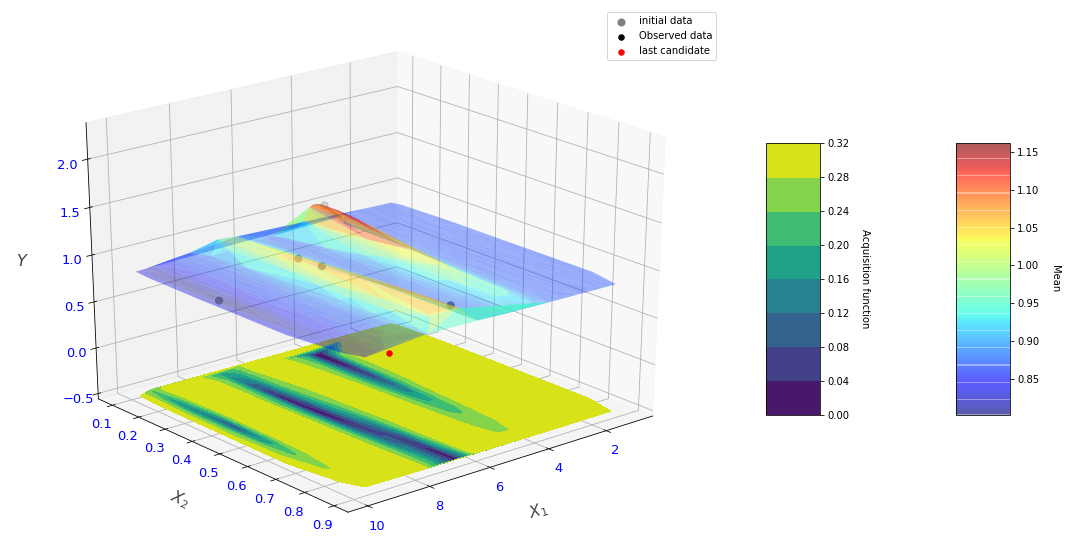

In [ ]:
plot_result(x_train,y_train,bounds,gaussian_process,acquisition_function)

In [ ]:
x_train,y_train = Bayesian_Optimization(x_train,y_train,bounds,objective_function,maximize,n_steps=10)

### Сохранить картинки

In [ ]:
from my_functions.bo2d_functions import generate_initial_data_2D
from my_functions.bo2d_functions import Bayesian_Optimization
from my_functions.objective_functions2d import unimodal_func1
from my_functions.objective_functions2d import LPA_stage
import torch

In [ ]:
r_min = [1.,0.1]
r_max = [10.,0.89]
n_points = 5
maximize=True

obj_type = 'desy_obj' # start with 1, not 0
filtered = True
objective_function = lambda varied_params: LPA_stage(varied_params,
                                                    filtered=filtered,
                                                    obj_type=obj_type) 

In [ ]:
x_train, y_train, bounds = generate_initial_data_2D(r_min, r_max, objective_function,n_points)


In [ ]:
torch.save(x_train, 'x_train.pt')
torch.save(y_train, 'y_train.pt')
torch.save(bounds, 'bounds.pt')

In [ ]:
x_train = torch.load('x_train.pt')
y_train = torch.load('y_train.pt')
bounds = torch.load('bounds.pt')

In [ ]:
x_train,y_train = Bayesian_Optimization(x_train,y_train,bounds,objective_function,maximize,n_steps=20)